# Homework 1

## Part 3: DiD

a) Write down a fixed effects regression equation that allows you to derive a difference in-difference estimate of the effect of the event on prices. Think of controls to
add, why is this relevant? Explain why you need a second city for this.

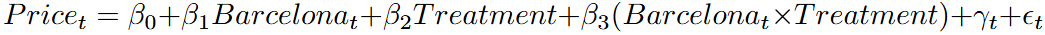

In the equation above:
- Price_it: Price of hotel i in time t.
- β₀: This coefficient is the intercept, reflecting the average price in the control group one week before the Formula 1 event.
- β₁: This coefficient measure the difference in prices between the control city and Barcelona before the event.
- β2: This coefficient represents the price difference in the control city during the Formula 1.
- β3: This coefficient represents the price change in Barcelona due to the Formula 1 event, and it is the DiD estimate. It considers the interaction between the treatment and the city, allowing us to get a causal effect of the Formula 1 event on prices un Barcelona. This is true if the common trend assumption holds.
- γt: is the time fixed effects coefficient in our model. This term accounts for any unobserved time-varying factors that could bias our estimation. This term ensures that any price change affecting both cities equally is not mistaken with β3.
- ϵ: is the error term.
​

In [1]:
# Importing Packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
# Importing data from CSV files
barcelona_t = pd.read_csv(r"C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\web_scrapping\Booking\data\hotel_data_barcelona_treatment.csv")
barcelona_c = pd.read_csv(r"C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\web_scrapping\Booking\data\hotel_data_barcelona_control.csv")
lisbon_t = pd.read_csv(r"C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\web_scrapping\Booking\data\hotel_data_lisbon_treatment.csv")
lisbon_c = pd.read_csv(r"C:\Users\aleja\OneDrive\Escritorio\Term_2\Text_Mining\web_scrapping\Booking\data\hotel_data_lisbon_control.csv")

In [3]:
# Counting rows in each DataFrame
print(f"Number of rows in Barcelona Treatment: {barcelona_t.shape[0]}")
print(f"Number of rows in Barcelona Control: {barcelona_c.shape[0]}")
print(f"Number of rows in Lisbon Treatment: {lisbon_t.shape[0]}")
print(f"Number of rows in Lisbon Control: {lisbon_c.shape[0]}")

Number of rows in Barcelona Treatment: 974
Number of rows in Barcelona Control: 990
Number of rows in Lisbon Treatment: 1000
Number of rows in Lisbon Control: 1000


In [4]:
# Creating a treatment column
barcelona_c['treatment'] = 0
barcelona_t['treatment'] = 1
lisbon_c['treatment'] = 0
lisbon_t['treatment'] = 1

# Creating a City column
barcelona_c['barcelona'] = 1
barcelona_t['barcelona'] = 1
lisbon_c['barcelona'] = 0
lisbon_t['barcelona'] = 0

# Concatenating the dataframes
df = pd.concat([barcelona_c, barcelona_t, lisbon_c, lisbon_t], axis=0)

In [5]:
df.head()

,Name,Price,Rating,Hotel Link,Description,treatment,barcelona
0,The Central House Barcelona Gracia,1158,8.6,https://www.booking.com/hotel/es/rodama3n-barc...,El TCH Barcelona Grácia está situado junto a l...,0,1
1,Sonder Paseo de Gracia,1313,8.2,https://www.booking.com/hotel/es/sonder-paseo-...,Sonder Paseo de Gracia está muy bien situado e...,0,1
2,Four Points by Sheraton Barcelona Airport,496,8.7,https://www.booking.com/hotel/es/four-points-b...,Four Points by Sheraton Barcelona Airport está...,0,1
3,ibis Styles Barcelona City Bogatell,699,8.4,https://www.booking.com/hotel/es/ibis-styles-b...,El ibis Styles Barcelona City Bogatell se encu...,0,1
4,Barcelona House,674,8.0,https://www.booking.com/hotel/es/barcelona-hou...,El Barcelona House Hotel se encuentra en el Ba...,0,1


### Checking avg prices before and during the event

In [6]:
# Group by both treatment (event timing) and city (Barcelona vs. Lisbon)
average_prices_by_city = df.groupby(['treatment', 'barcelona'])['Price'].mean().unstack()
# Renaming columns for better clarity
average_prices_by_city.columns = ['Lisbon', 'Barcelona']

# Display results
print("\nAverage Prices Before and During the Event by City:")
print(average_prices_by_city)


Average Prices Before and During the Event by City:
            Lisbon    Barcelona
treatment                      
0          976.945  1289.108081
1          763.465  1826.013347


### Common trend assumption

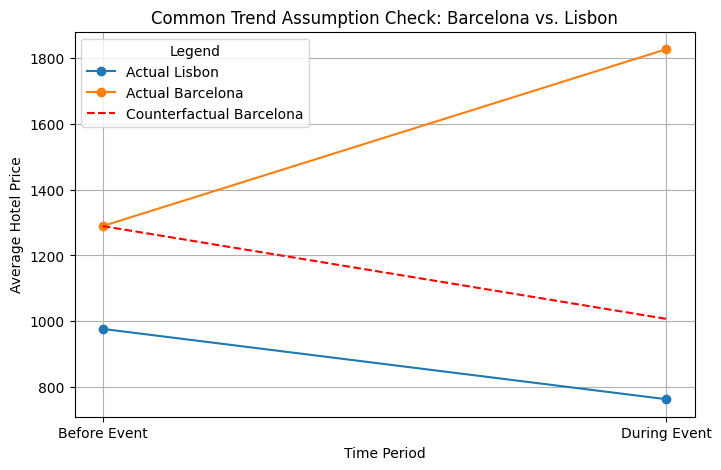

In [8]:
# Calculate average price for each treatment period and city
avg_prices = df.groupby(['treatment', 'barcelona'])['Price'].mean().reset_index()

# Rename values for clarity
avg_prices['City'] = avg_prices['barcelona'].map({0: 'Lisbon', 1: 'Barcelona'})
avg_prices['Time'] = avg_prices['treatment'].map({0: 'Before Event', 1: 'During Event'})

# Calculate the counterfactual trend for Barcelona
lisbon_prices_before = avg_prices[(avg_prices['City'] == 'Lisbon') & (avg_prices['treatment'] == 0)]['Price'].values[0]
lisbon_prices_during = avg_prices[(avg_prices['City'] == 'Lisbon') & (avg_prices['treatment'] == 1)]['Price'].values[0]

# Calculate the percentage change in Lisbon's prices (control group trend)
lisbon_price_change = (lisbon_prices_during - lisbon_prices_before) / lisbon_prices_before

# Project Barcelona's counterfactual prices (if it had followed Lisbon's trend)
barcelona_prices_before = avg_prices[(avg_prices['City'] == 'Barcelona') & (avg_prices['treatment'] == 0)]['Price'].values[0]
barcelona_counterfactual_during = barcelona_prices_before * (1 + lisbon_price_change)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot actual price trends
for city in avg_prices['City'].unique():
    subset = avg_prices[avg_prices['City'] == city]
    plt.plot(subset['treatment'], subset['Price'], marker='o', linestyle='-', label=f"Actual {city}")

# Plot counterfactual line for Barcelona
plt.plot([0, 1], [barcelona_prices_before, barcelona_counterfactual_during], linestyle='--', color='red', label="Counterfactual Barcelona")

# Customize the plot
plt.xlabel('Time Period')
plt.ylabel('Average Hotel Price')
plt.title('Common Trend Assumption Check: Barcelona vs. Lisbon')
plt.xticks([0, 1], ['Before Event', 'During Event'])
plt.legend(title='Legend')
plt.grid(True)

# Show the plot
plt.show()

### DiD Estimation

In [26]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Create the Interaction Term (DiD Variable)
df['did'] = df['barcelona'] * df['treatment']

# Run Fixed Effects Model with Time and City Fixed Effects
model_fe = smf.ols('Price ~ treatment + barcelona + did', data=df).fit()

# Get robust standard errors
robust_model = model_fe.get_robustcov_results(cov_type='HC1')

# Print results
print(robust_model.summary())



                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     340.1
Date:                Fri, 31 Jan 2025   Prob (F-statistic):          1.63e-196
Time:                        14:35:50   Log-Likelihood:                -31922.
No. Observations:                3964   AIC:                         6.385e+04
Df Residuals:                    3960   BIC:                         6.388e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    976.9450     17.849     54.735      0.0

(b) How would you use text features from the description as controls? Think about
the text in the descriptions you scraped. How would this help? Why would terms
like "Barcelona" not help?


(c) Now suppose we want to decompose the treatment effect by hotel quality. Can
you use the text description here? How would you use them to study heterogenous
treatment effects? Write down a regression equation.
